In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
import pandas as pd
from protnote.utils.data import read_fasta
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import obonet
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler
from protnote.utils.data import generate_vocabularies
from scipy.stats import spearmanr,pearsonr
import matplotlib.colors as mcolors
from protnote.utils.data import get_ec_class_descriptions,read_json
from sklearn.metrics.pairwise import pairwise_distances 
from scipy.stats import ttest_ind, ttest_1samp
from itertools import product
from protnote.utils.notebooks import *
from torcheval.metrics.functional import binary_precision_recall_curve
from torcheval.metrics.functional import multilabel_auprc
from protnote.utils.protex import *
from tqdm import tqdm

ec_class_descriptions = get_ec_class_descriptions('../data/annotations/enzclass.txt')
ontology2alias = {'molecular_function':'MF','biological_process':'BP','cellular_component':'CC','All':'All'}
graph = obonet.read_obo('../data/annotations/go_2024-06-17.obo')
device = 'cuda'
parenthood_2019 = read_json('../data/vocabularies/parenthood_jul_2019.json')
plt.rcParams['font.size'] = 14
os.makedirs('../outputs/figures',exist_ok=True)
threshold = 0.3


/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Embeddings (fig 3 and S7)

Declaring constants

In [2]:
embeddings = torch.load('../outputs/results/test_1_embeddings_TEST_TOP_LABELS_DATA_PATH_seed_replicates_v9_42_sum_last_epoch/batches_0_99.pt',
               map_location='cpu')

num_seqs = 800
num_labels = embeddings['labels'].shape[-1]
vocab = generate_vocabularies('../data/swissprot/proteinfer_splits/random/test_top_labels_GO.fasta')['label_vocab']
graph_2019 = obonet.read_obo('../data/annotations/go_2019-07-01.obo')
vocab_parents = [(graph_2019.nodes[go_term]["namespace"] if  go_term in graph_2019.nodes else 'missing') for go_term in vocab]
joint_embedding_dim = embeddings['joint_embeddings'].shape[-1]


### Sequence embedding and label correlations

/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


(800, 800)


label sim = jaccard_sim, seqs sim = cos_sim
pearson = PearsonRResult(statistic=0.5330794850656138, pvalue=0.0), spearman = SignificanceResult(statistic=0.3153036749464395, pvalue=0.0) 


(640000,)


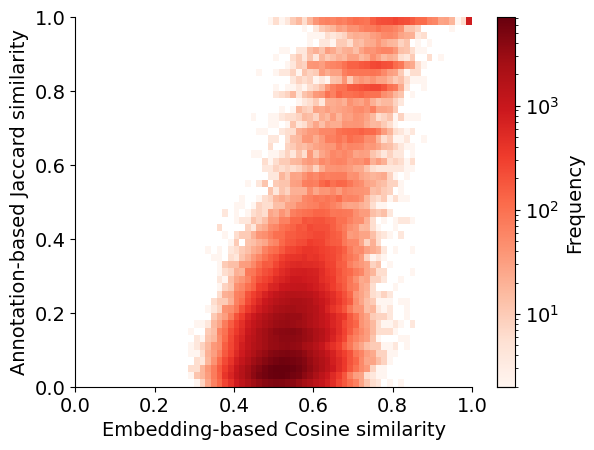

(1502, 1502)


label sim = cos_sim, seqs sim = cos_sim
pearson = PearsonRResult(statistic=0.40405867344032304, pvalue=0.0), spearman = SignificanceResult(statistic=0.3398965705579301, pvalue=0.0) 


(2256004,)


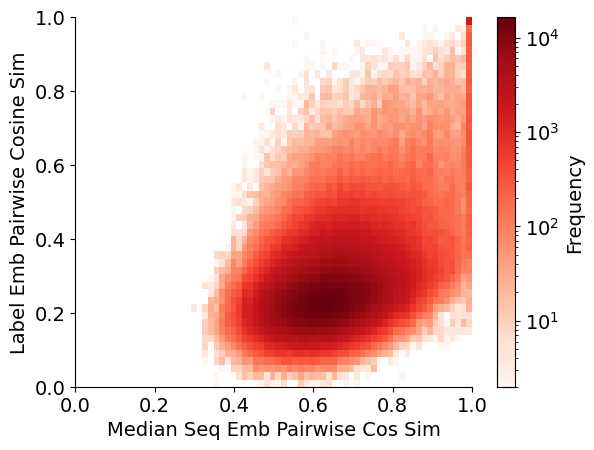

In [3]:
# Correlation between embedding similarty and annotation-based similiary with Jaccard dist.
seq_embeddings = embeddings['joint_embeddings'][range(0,num_labels*num_seqs,num_labels),:joint_embedding_dim//2]
labels = embeddings['labels']


label_similarities = {
    'jaccard_sim':1 - pairwise_distances(X=labels, metric="jaccard", n_jobs=-1)
    }

sequence_similarities = {
    'cos_sim': 1 - pairwise_distances(X=seq_embeddings, metric="cosine", n_jobs=-1)
                }
print(sequence_similarities['cos_sim'].shape)

for seq_sims,label_sims in zip(sequence_similarities.items(),label_similarities.items()):
    spearman = spearmanr(seq_sims[1].flatten(),label_sims[1].flatten())
    pearson = pearsonr(seq_sims[1].flatten(),label_sims[1].flatten())
    print('\n')
    print(f'label sim = {label_sims[0]}, seqs sim = {seq_sims[0]}')
    print(f'pearson = {pearson}, spearman = {spearman} ')
    print('\n')

    print(seq_sims[1].flatten().shape)
    plt.hist2d(x=seq_sims[1].flatten(),y=label_sims[1].flatten(), bins=50, cmap='Reds',norm=mcolors.LogNorm())
    plt.colorbar(label='Frequency')
    sns.despine()
    plt.xlabel('Embedding-based Cosine similarity')
    plt.ylabel('Annotation-based Jaccard similarity')
    plt.xlim(0,1)
    plt.ylim(0,1)
    save_fig("../outputs/figures/seq_embeddings_2d_hist")
    plt.show()


    
#Get a sequence representation as the median embedding of their positive annotations. 
#Compute correlation with pairwise label emedding similarity
label_embeddings = embeddings['joint_embeddings'][:num_labels,joint_embedding_dim//2:]
label_mask = (labels.T.sum(axis=1)!=0)

agg_seq_embeddings = np.vstack([np.median(seq_embeddings[labels.T[i].astype(bool)],axis=0) for i in range(len(labels.T)) if labels.T[i].sum()>0])

label_similarities = {
    'cos_sim': 1 - pairwise_distances(X=label_embeddings[label_mask], metric="cosine", n_jobs=-1)
    }

sequence_similarities = {
    'cos_sim': 1 - pairwise_distances(X=agg_seq_embeddings, metric="cosine", n_jobs=-1)
                }

print(sequence_similarities['cos_sim'].shape)

for seq_sims,label_sims in zip(sequence_similarities.items(),label_similarities.items()):
    spearman = spearmanr(seq_sims[1].flatten(),label_sims[1].flatten())
    pearson = pearsonr(seq_sims[1].flatten(),label_sims[1].flatten())
    print('\n')
    print(f'label sim = {label_sims[0]}, seqs sim = {seq_sims[0]}')
    print(f'pearson = {pearson}, spearman = {spearman} ')
    print('\n')

    print(seq_sims[1].flatten().shape)
    plt.hist2d(x=seq_sims[1].flatten(),y=label_sims[1].flatten(), bins=50, cmap='Reds',norm=mcolors.LogNorm())
    plt.colorbar(label='Frequency')
    sns.despine()
    plt.ylabel('Label Emb Pairwise Cosine Sim')
    plt.xlabel('Median Seq Emb Pairwise Cos Sim')
    plt.xlim(0,1)
    plt.ylim(0,1)
    save_fig("../outputs/figures/label_embeddings_2d_hist")
    plt.show()



### UMAP Output layer embeddings

Warning, the following UMAP code takes ~9min to run and consumes ~50GB of RAM in 24vCore VM. Exact visual may differ from the paper due to UMAP's randomness - the umap-learn package allows setting a random seed but without multi-core processing, which would make creating this visual much slower.

In [3]:
num_seqs = 100
X = embeddings['output_layer_embeddings'][:num_labels*num_seqs,:]
sc = StandardScaler()
X_s = sc.fit_transform(X)

hue = vocab_parents*(num_seqs)
match_binary_mask = embeddings['labels'][:num_seqs,:].flatten()

palette = sns.color_palette("tab10")


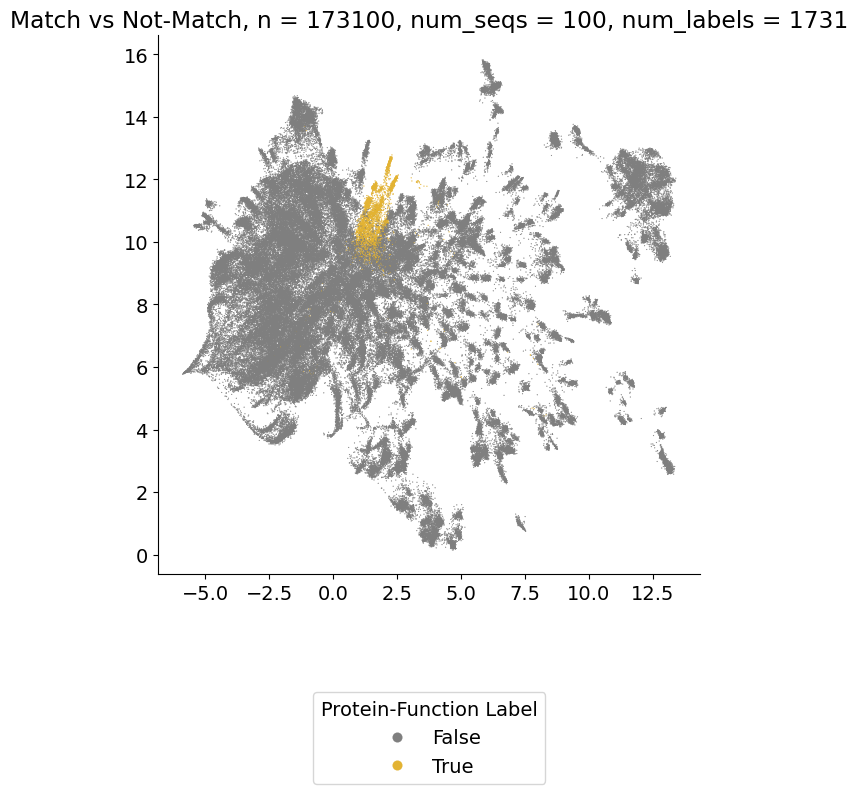

In [45]:

# output layer showing separation between matching and un-matching protein-function pairs
fig = plt.figure(figsize=(7,7))
X_r = umap.UMAP(
        n_neighbors=200,
        min_dist=0.3).fit(X_s).embedding_
palette_ = palette[7:8] + [(227/255,179/255,51/255)]
sns.scatterplot(x=X_r[:,0],y=X_r[:,1],marker='.',s = 2, hue=match_binary_mask,edgecolor=None,palette=palette_)
plt.legend(markerscale=10,title="Protein-Function Label", bbox_to_anchor=(0.5, -0.2), loc='upper center')
sns.despine()
plt.title(f'Match vs Not-Match, n = {len(X_r)}, num_seqs = {num_seqs}, num_labels = {num_labels}')
save_fig('../outputs/figures/match_vs_notmatch')
plt.show()



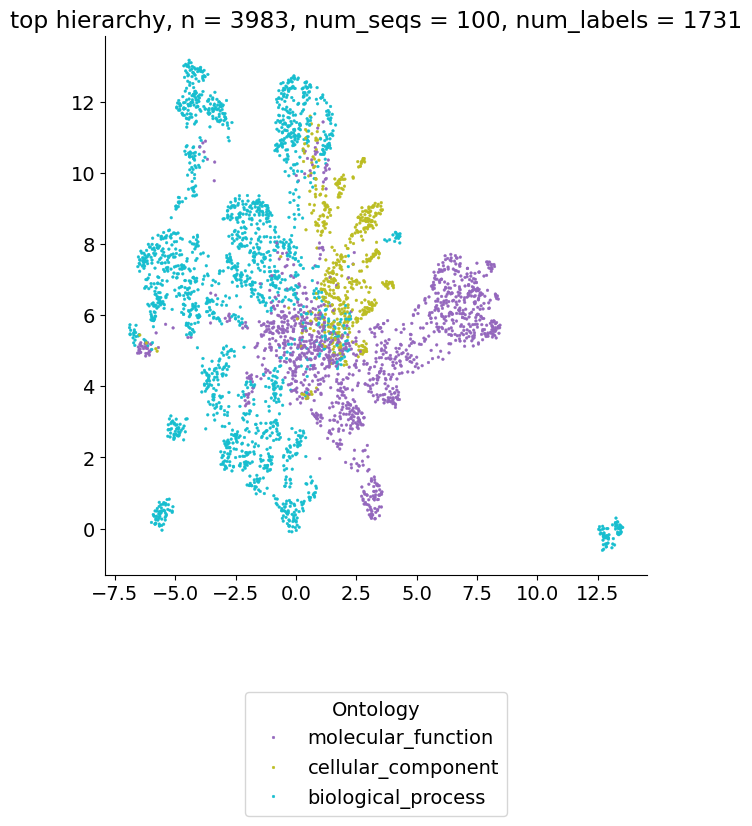

In [4]:

# Positive pairs of output layer colored by GO Top hierarchy
fig = plt.figure(figsize=(7,7))
palette_ = palette[4:5] + palette[8:10]
match_binary_mask = match_binary_mask.astype(bool)
X_r = umap.UMAP(
    n_neighbors=50,
    min_dist=0.5).fit(X_s[match_binary_mask]).embedding_
sns.scatterplot(x=X_r[:,0],
                y=X_r[:,1],
                marker='.',
                hue=[hue_val for hue_val,binary_mask_val in zip(hue,match_binary_mask) if binary_mask_val],
                s=15,
                edgecolor=None,
                palette=palette_)
plt.legend(markerscale=1,title="Ontology", bbox_to_anchor=(0.5, -0.2), loc='upper center')
sns.despine()
plt.title(f'top hierarchy, n = {len(X_r)}, num_seqs = {num_seqs}, num_labels = {num_labels}')
save_fig('../outputs/figures/positives_by_ontology')
plt.show()



# Explore Datasets

In [3]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')
zero_shot = read_fasta('../data/zero_shot/GO_swissprot_jul_2024.fasta')
zero_shot_ln = read_fasta('../data/zero_shot/GO_swissprot_leaf_nodes_jul_2024.fasta')
ec = read_fasta('../data/zero_shot/test_EC.fasta')

for dataset in ['train','val','test','zero_shot','zero_shot_ln','ec']:
    exec(f'{dataset} = [(seq,id," ".join(labels),"{dataset}") for seq,id,labels in {dataset}]')

df = train + val + test + zero_shot + zero_shot_ln + ec
df = pd.DataFrame(df,columns=['sequence','id','labels','split'])

In [4]:
df['sequence_len'] = df['sequence'].str.len()
df['label_splits'] = df['labels'].str.split()
df['labels_per_seq'] = df['label_splits'].apply(len)

datasets_stats = df.groupby('split').agg(
    num_sequences=('sequence', 'count'),
    num_unique_sequences=('sequence', 'nunique'),
    median_seq_len=('sequence_len', 'median'),
    max_seq_len=('sequence_len', 'max'),
    median_labels_per_seq=('labels_per_seq', 'median'),
    max_labels_per_seq=('labels_per_seq', 'max')
)


for dataset in datasets_stats.index:
    datasets_stats.loc[dataset,'num_unique_labels'] = len(set([l for ls in eval(dataset) for l in ls[-2].split() ]))


datasets_stats


,num_sequences,num_unique_sequences,median_seq_len,max_seq_len,median_labels_per_seq,max_labels_per_seq,num_unique_labels
split,,,,,,,
ec,25892,21870,347.0,8903,4.0,22,2534.0
test,51751,43575,301.0,11103,43.0,815,22026.0
train,418015,351429,303.0,35213,43.0,1008,31365.0
val,52841,44362,303.0,10061,43.0,760,21914.0
zero_shot,63594,56212,303.0,15639,1.0,14,614.0
zero_shot_ln,2445,2276,430.0,7158,1.0,6,402.0


GO Term distribution (fig S8)

# GO Terms: 31365 

GO Terms distribution:


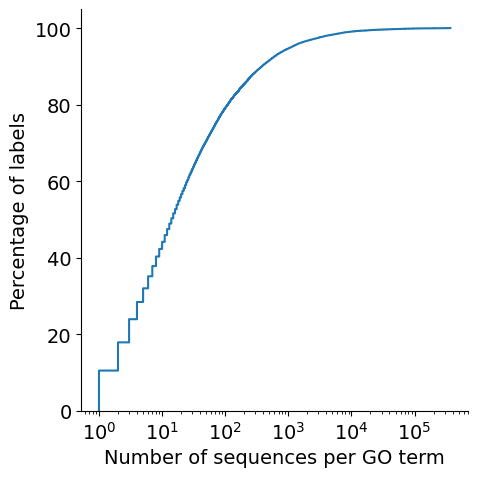

In [5]:
vocab,amino_freq,labels = get_data_distributions(df[df['split']=='train'])
print('# GO Terms:',len(labels.keys()),'\n')

print('GO Terms distribution:')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

go_dist = go_term_distribution.reset_index().rename(columns={'index':'GO term',0:'Number of sequences per GO term'})
sns.displot(data=go_dist,x='Number of sequences per GO term',log_scale=True,kind='ecdf',stat='percent')
plt.ylabel('Percentage of labels')
save_fig('../outputs/figures/GO Term Distribution')
plt.show()

Distribution of ontologies in the training set

In [6]:

#sum by ontology
go_dist = pd.DataFrame([(graph_2019.nodes[go_term]["namespace"],freq) for go_term,freq in dict(labels).items() if go_term in graph_2019.nodes]).groupby(0).sum().sort_values(1,ascending=False).reset_index()
go_dist.columns = ['Ontology','Number of sequences']
#calculate percentage
go_dist['Percentage'] = go_dist['Number of sequences']*100/go_dist['Number of sequences'].sum()
go_dist

,Ontology,Number of sequences,Percentage
0,biological_process,11645586,58.384623
1,molecular_function,5349068,26.817312
2,cellular_component,2951670,14.798065


# Zero Shot Performance

Read predictions and labels for the different datasets

In [3]:
seeds = [12,22,32,42,52]
model_checkpoint = 'seed_replicates_v9_12_sum_last_epoch'

zero_shot_labels = {'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':('Leaf Nodes',pd.read_hdf(f'../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_{model_checkpoint}.h5',key='labels_df')),
                    'TEST_DATA_PATH_ZERO_SHOT':('Leaf Nodes + Inferred',pd.read_hdf(f'../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_{model_checkpoint}.h5',key='labels_df')),
                    'TEST_EC_DATA_PATH_ZERO_SHOT':('EC Zero Shot',pd.read_hdf(f'../outputs/results/test_1_labels_TEST_EC_DATA_PATH_ZERO_SHOT_{model_checkpoint}.h5',key='labels_df'))
                    }

zero_shot_predictions = {'ProtNote':{'TEST_DATA_PATH_ZERO_SHOT':[pd.read_hdf(f"../outputs/results/test_1_logits_TEST_DATA_PATH_ZERO_SHOT_seed_replicates_v9_{seed}_sum_last_epoch.h5",key='logits_df') for seed in seeds],
                                 'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':[pd.read_hdf(f"../outputs/results/test_1_logits_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_seed_replicates_v9_{seed}_sum_last_epoch.h5",key='logits_df') for seed in seeds],
                                  'TEST_EC_DATA_PATH_ZERO_SHOT':[pd.read_hdf(f"../outputs/results/test_1_logits_TEST_EC_DATA_PATH_ZERO_SHOT_seed_replicates_v9_{seed}_sum_last_epoch.h5",key='logits_df') for seed in seeds]
                                 },
                          'baseline_e5':{'TEST_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_E5_baseline.h5",key='logits_df')],
                                        'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_E5_baseline.h5",key='logits_df')],
                                        'TEST_EC_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_EC_TEST_EC_DATA_PATH_ZERO_SHOT_E5_baseline.h5",key='logits_df')]
                                 },
                           'baseline_biogpt':{'TEST_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_BioGPT_baseline.h5",key='logits_df')],
                                          'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_BioGPT_baseline.h5",key='logits_df')],
                                          'TEST_EC_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_EC_TEST_EC_DATA_PATH_ZERO_SHOT_BioGPT_baseline.h5",key='logits_df')]
                                 }
                        }


### GO Zero Shot Performance (Figs S1 and 4)

Compute metrics for all models and datasets

In [4]:
model = "ProtNote"
test_set = "TEST_DATA_PATH_ZERO_SHOT"
labels_df = zero_shot_labels[test_set][-1]
logits_df = zero_shot_predictions[model][test_set][0]

In [5]:

test_sets = ['TEST_DATA_PATH_ZERO_SHOT', 'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES']
metrics = ['mAP Macro','mAP Micro']
category_name = 'Ontology'
go_zs_final_metrics_df = []

for model in zero_shot_predictions.keys():
    for test_set in test_sets:
        labels_df = zero_shot_labels[test_set][-1]
        test_name = zero_shot_labels[test_set][0]
        if test_set not in zero_shot_predictions[model]:
            continue

        for logits_df in zero_shot_predictions[model][test_set]:
            metrics_df = metrics_by_go_ontology(df_logits=logits_df,
                                df_labels=labels_df,
                                graph=graph,
                                device=device,
                                threshold=threshold)

            metrics_df = pd.DataFrame(metrics_df)
            metrics_df['model'] = model
            metrics_df['test_name'] = test_name
            metrics_df.index.name = 'metric'
            metrics_df = metrics_df.set_index(['model','test_name'],append=True)

            go_zs_final_metrics_df.append(metrics_df)
go_zs_final_metrics_df  = pd.concat(go_zs_final_metrics_df)
go_zs_final_metrics_df.columns = go_zs_final_metrics_df.columns.map(ontology2alias)


Detailed GO Zero shot performance fig S1

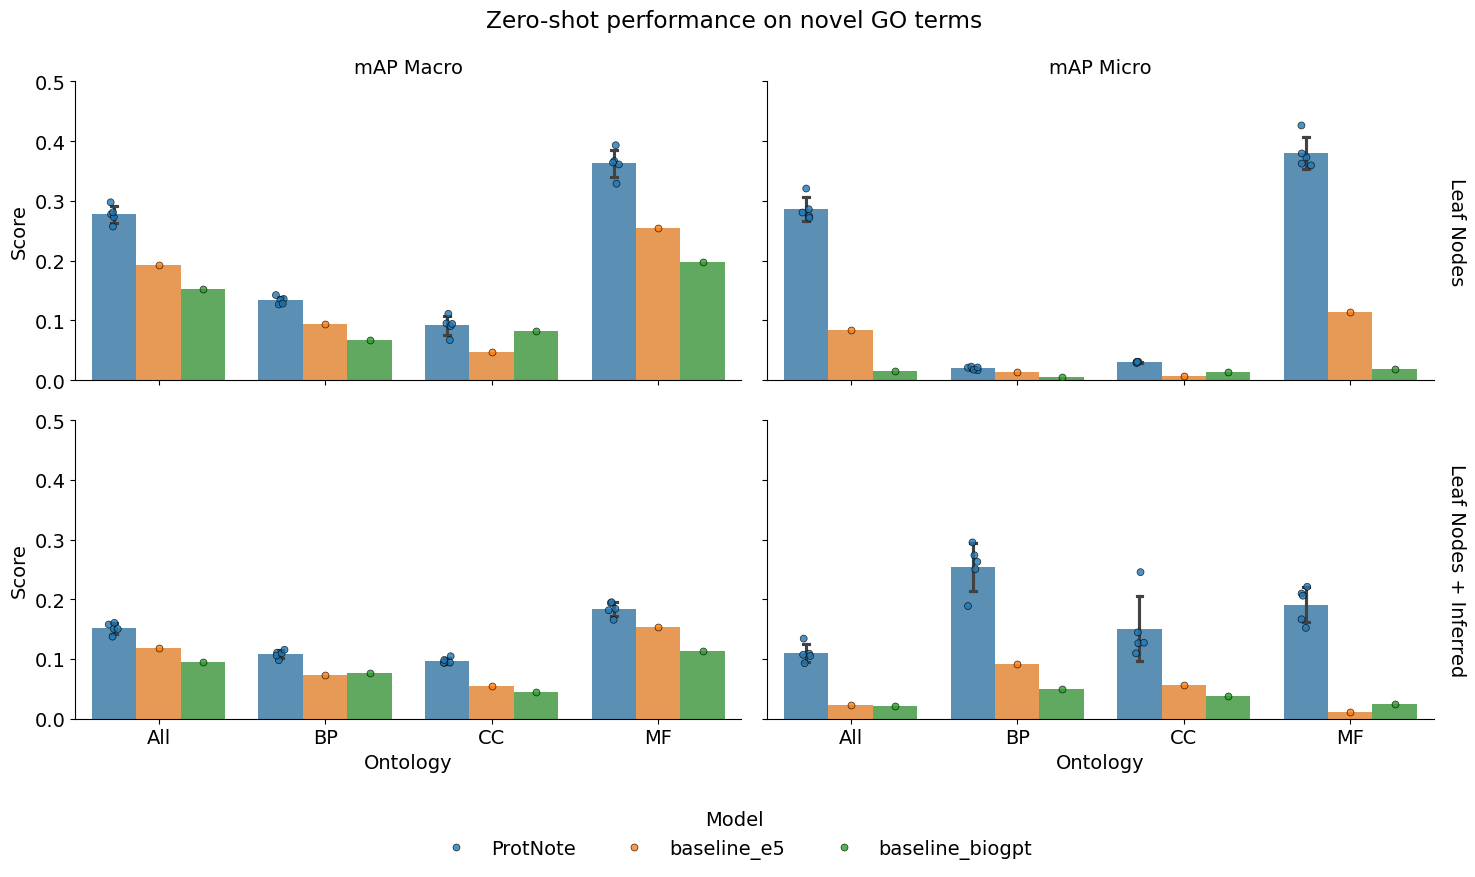

In [6]:
g = sns.FacetGrid(data = go_zs_final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  row='test_name',
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=4,
                  aspect=1.1,
                  row_order=['Leaf Nodes','Leaf Nodes + Inferred'])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.figure.suptitle('Zero-shot performance on novel GO terms')
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.5,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)
g.add_legend(title='Model', bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.tight_layout()
save_fig(name = '../outputs/figures/Detailed GO ZS')
plt.show()

Simplified Zero shot performance fig 4

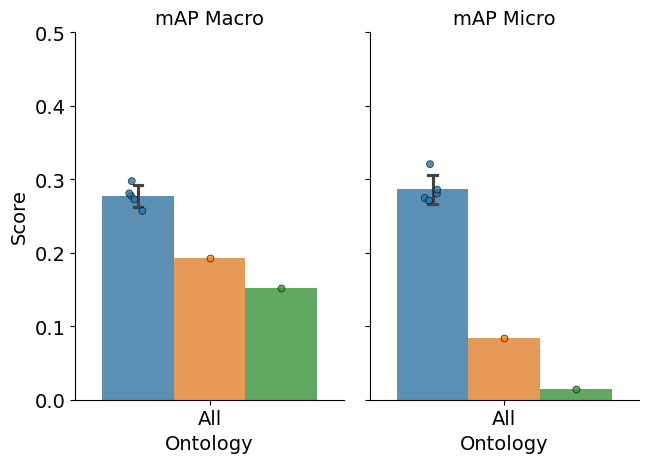

In [7]:
g = sns.FacetGrid(data = go_zs_final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"] and Ontology == "All" and test_name == "Leaf Nodes"'),
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=2.43*2,
                  aspect=.69,
                  row_order=['Leaf Nodes','Leaf Nodes + Inferred']
                  )
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                # err_kws={'linewidth':1.3},
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.5,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)
plt.tight_layout()
save_fig(name = '../outputs/figures/GO ZS')

### EC Zero Shot Performance (Figs S3 and 4)

Compute metrics for all models and datasets

In [8]:

test_sets = ['TEST_EC_DATA_PATH_ZERO_SHOT']
metrics = ['mAP Macro','mAP Micro']
ec_zs_final_metrics_df = []
category_name = 'Top-level EC Class'
device = 'cuda'
for model in zero_shot_predictions.keys():
    for test_set in test_sets:
        if test_set not in zero_shot_predictions[model]:
            continue
        labels_df = zero_shot_labels[test_set][-1]
        test_name = zero_shot_labels[test_set][0]
        for logits_df in zero_shot_predictions[model][test_set]:
            metrics_df = metrics_by_ec_level_1(df_logits=logits_df,
                                            df_labels=labels_df,
                                            ec_class_descriptions=ec_class_descriptions,
                                            device=device,
                                            threshold=threshold)

            metrics_df = pd.DataFrame(metrics_df)
            metrics_df['model'] = model
            metrics_df['test_name'] = test_name
            metrics_df.index.name = 'metric'
            metrics_df = metrics_df.set_index(['model','test_name'],append=True)
            ec_zs_final_metrics_df.append(metrics_df)
ec_zs_final_metrics_df  = pd.concat(ec_zs_final_metrics_df)        

Detailed Zero Shot Performance (Fig S3)

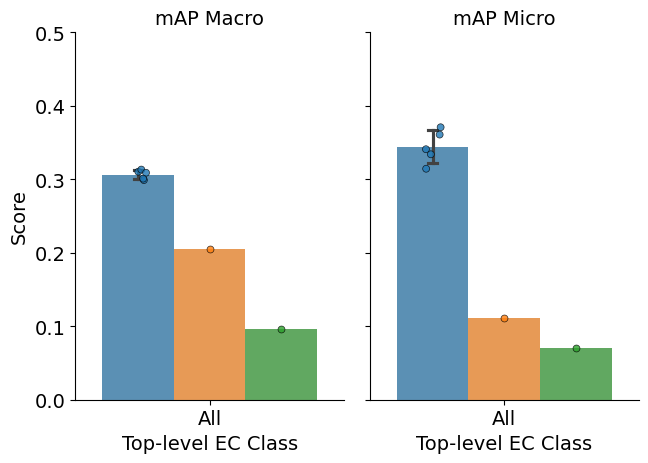

In [9]:
g = sns.FacetGrid(data = ec_zs_final_metrics_df[["All"]]\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query(f'metric in ["mAP Macro","mAP Micro"]'),
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=2.43*2,
                  aspect=.69,
                  legend_out=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.5,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)

plt.tight_layout()
save_fig(name = '../outputs/figures/EC ZS')


Simplified Zero Shot Performance Fig 4

/tmp/ipykernel_1413562/1427828866.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
/tmp/ipykernel_1413562/1427828866.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)


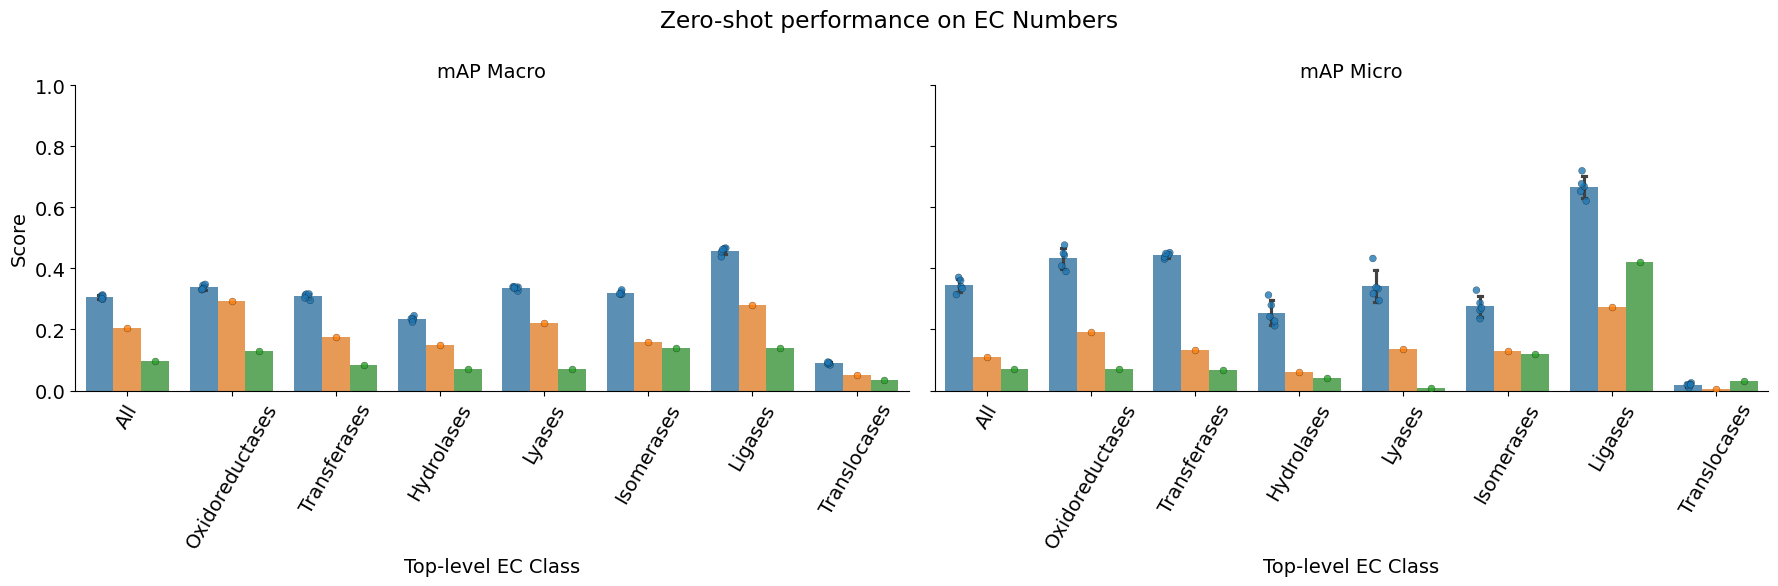

In [10]:

g = sns.FacetGrid(data = ec_zs_final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  col='metric',
                  despine=True,
                  ylim=(0,1),
                  margin_titles=True,
                  height=6,
                  aspect=1.5,
                  legend_out=True)
g.figure.suptitle('Zero-shot performance on EC Numbers')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.2,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)

plt.tight_layout()
save_fig(name = '../outputs/figures/Detailed EC ZS')


# Supervised Performance (Figs S2 and 2 )

In [11]:
supervised_final_metrics_df = pd.read_parquet('../outputs/results/supervised_metrics_df.parquet')

In [16]:


supervised_metric_table = (supervised_final_metrics_df.query('metric in ["mAP Macro","mAP Micro"]').groupby(['model','metric']).agg(['mean','std']).stack(0).unstack('metric')*100).round(2)
supervised_metric_table.columns = ['_'.join(i) for i in supervised_metric_table.columns]
supervised_metric_table = supervised_metric_table[['mean_mAP Macro','std_mAP Macro','mean_mAP Micro','std_mAP Micro']]
supervised_metric_table.index.names = ['Model','Ontology']
supervised_metric_table = supervised_metric_table.reorder_levels([1,0],axis=0).sort_index()
supervised_metric_table

mean_mAP Macro  std_mAP Macro  mean_mAP Micro  \
Ontology Model                                                           
All      ProtNote                 60.19           0.11           90.42   
         Proteinfer               64.18           0.15           90.32   
         baseline_blast           52.49            NaN           78.99   
BP       ProtNote                 56.87           0.12           87.86   
         Proteinfer               58.77           0.23           87.43   
         baseline_blast           45.41            NaN           74.45   
CC       ProtNote                 58.72           0.34           89.69   
         Proteinfer               63.75           0.22           89.22   
         baseline_blast           54.38            NaN           76.34   
MF       ProtNote                 70.77           0.13           96.60   
         Proteinfer               80.59           0.16           96.45   
         baseline_blast           72.92            NaN           91.24   

                         std_mAP Micro  
Ontology Model                          
All      ProtNote                 0.14  
         Proteinfer               0.08  
         baseline_blast            NaN  
BP       ProtNote                 0.24  
         Proteinfer               0.12  
         baseline_blast            NaN  
CC       ProtNote                 0.12  
         Proteinfer               0.06  
         baseline_blast            NaN  
MF       ProtNote                 0.04  
         Proteinfer               0.06  
         baseline_blast            NaN

Precision Recall Curves

In [17]:
seeds = [
    12,
    22,
    32,
    42,
    52
    ]
pinf_model_ids = [
                  13703706,
                  # 13703742,
                  # 13703997,
                  13704131,
                  13705631
                  ]
labels_df = pd.read_hdf('../outputs/results/test_1_labels_TEST_DATA_PATH_seed_replicates_v9_12_sum_last_epoch.h5',key='labels_df')


models = {   **{f'ProtNote_{seed}':f'test_1_logits_TEST_DATA_PATH_seed_replicates_v9_{seed}_sum_last_epoch.h5' for seed in seeds},
             **{f'ProteInfer_{id}':f'test_logits_GO_TEST_DATA_PATH_proteinfer{id}.h5' for id in pinf_model_ids},
               'BLAST':'blast_pivot_parsed_test_GO_train_GO_results_fixed.parquet'
               }

prcurve_df = []
for model,model_preds in tqdm(models.items(),total=len(models.keys())):
    if model_preds.endswith("h5"):
        logits_df = pd.read_hdf(f'../outputs/results/{model_preds}',key='logits_df')
    elif model_preds.endswith("parquet"):
        logits_df = pd.read_parquet(f'../outputs/results/{model_preds}')
    precision, recall, thresholds = binary_precision_recall_curve(
        input=torch.tensor(logits_df.values.flatten(),device='cuda'),
        target=torch.tensor(labels_df.values.flatten(),device='cuda')
    )
    


    prcurve_model_df = pd.DataFrame({'precision':precision.cpu().numpy(),
                                        'recall':recall.cpu().numpy(),
                                        'model':model,
                                        'model_path':model_preds,
                                        'model_type':model.split('_')[0]
                                        })
    prcurve_df.append(prcurve_model_df)
prcurve_df = pd.concat(prcurve_df)
        

100%|██████████| 9/9 [01:16<00:00,  8.51s/it]


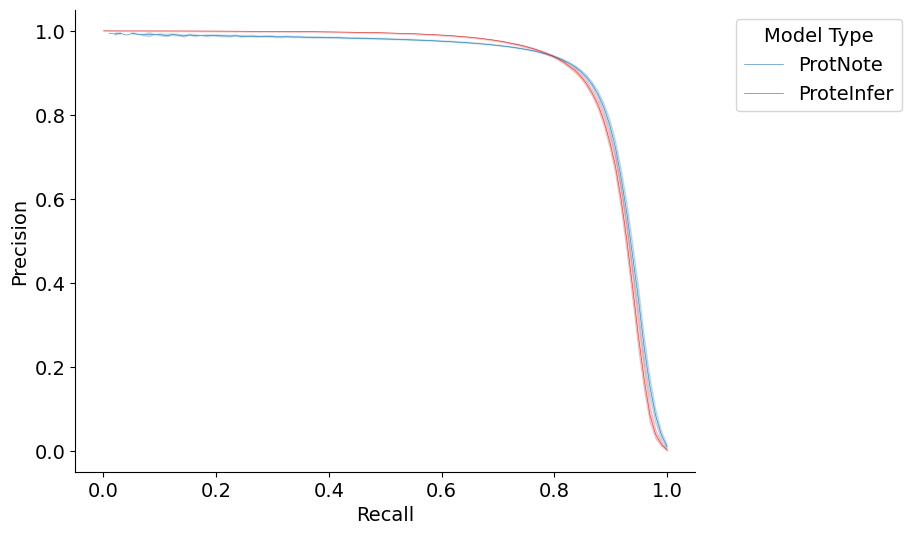

In [31]:

num_bins = 100
prcurve_df['recall_bins'] = pd.cut(prcurve_df['recall'],bins=np.linspace(0,1,num_bins),labels=np.linspace(0,1,num_bins-1))
prcurve_df['recall_bin_counts'] = prcurve_df.groupby(['model_type','recall_bins'])['recall'].transform('count')
prcurve_df_binned = prcurve_df.groupby(['model_type','recall_bins']).agg(
    precision_mean=('precision','mean'),
    precision_std=('precision','std')
).reset_index()

palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:5]
palette_ = {m:p for m,p in zip(['ProtNote','ProteInfer','BLAST'],palette_)}
# PR Curve by model type with error bars using seaborn lineplot in a single plot
fig, ax = plt.subplots(figsize=(8,6))

#fill between
for model_type in prcurve_df_binned.dropna()['model_type'].unique():
    model_df = prcurve_df_binned[prcurve_df_binned['model_type']==model_type]
    # +- std
    ax.fill_between(model_df['recall_bins'],
                    model_df['precision_mean']-model_df['precision_std'],
                    model_df['precision_mean']+model_df['precision_std'],
                    alpha=0.2,
                    color=palette_[model_type]
                    )

    # mean
    ax.plot(model_df['recall_bins'],model_df['precision_mean'],label=model_type,linewidth=0.4,color=palette_[model_type])
    
    
sns.despine()
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall Curve by model type')
plt.legend(title='Model Type',bbox_to_anchor=(1.05, 1), loc='upper left')
save_fig('../outputs/figures/PR Curve by model type')
plt.show()



In [10]:

# fig,ax = plt.subplots(figsize=(7,7))

# for model in prcurve_df['model'].unique():
#     d = prcurve_df.query(f"model=='{model}'")
#     sns.lineplot(data = d,
#                  x='recall',
#                  y='precision',
#                  color = palette_[d['model_type'].values[0]],
#                  label=model
#                  )
#     ax.legend(title='Model', bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
#     sns.despine()
#     # plt.xlim(0,1)
#     # plt.ylim(0,1)
# save_fig(name = '../outputs/figures/Supervised GO PR Curve')
# plt.show()

Simplified GO results (Fig 2)

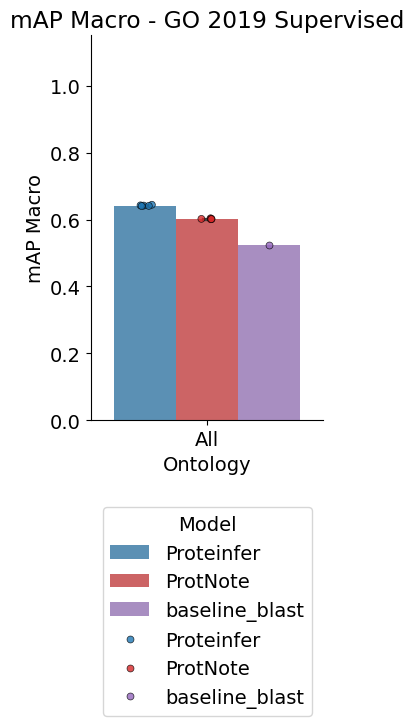

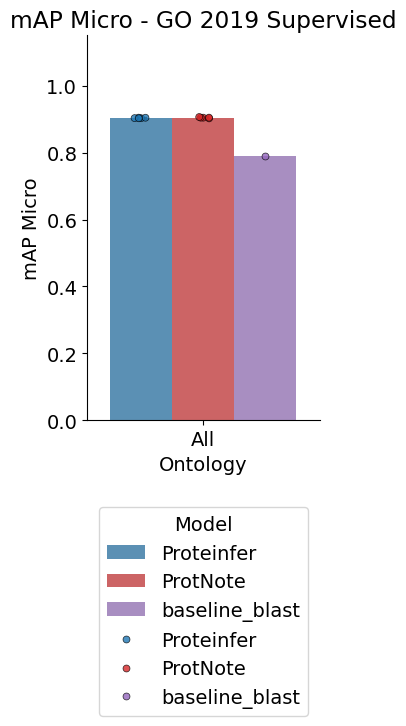

In [79]:
palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:5]
test_name = 'GO 2019 Supervised'
for metric in ['mAP Macro','mAP Micro']:
    plot_category_performance(metrics_df = supervised_final_metrics_df[['All']],
                            test_name=test_name,
                            metric = metric,
                            category_name = 'Ontology',
                            ylim=(0,1.15),
                            figsize=(3,5),
                            palette=palette_,
                            name=f'../outputs/figures/Supervised GO {metric}',
                            savefig=True
                            )
    

Detailed GO supervised results (Fig S2)

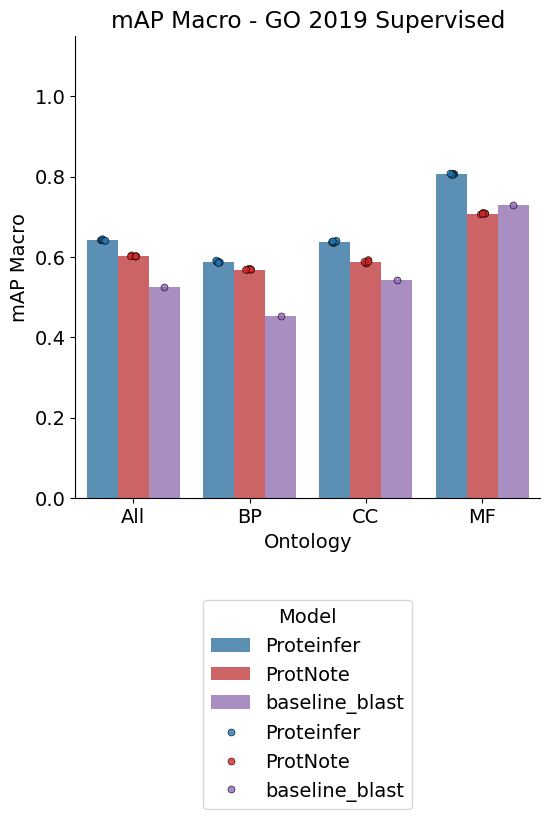

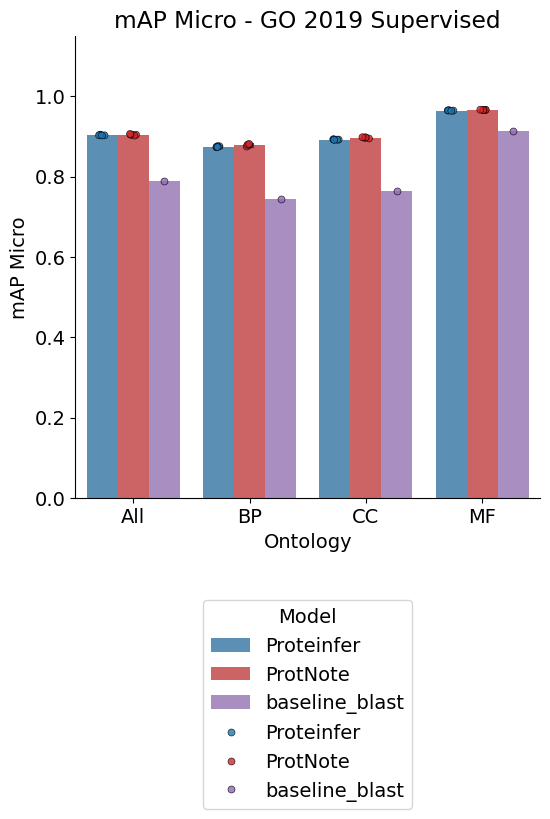

In [80]:
palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:5]

for metric in ['mAP Macro','mAP Micro']:
    plot_category_performance(metrics_df = supervised_final_metrics_df,
                            test_name=test_name,
                            metric = metric,
                            category_name = 'Ontology',
                            ylim=(0,1.15),
                            name=f'../outputs/figures/Detailed Supervised GO {metric}',
                            palette=palette_,
                            figsize=(3*2,3*2),
                            savefig=True
                            )


Welchl's t-tests

In [35]:
t_test_results = []
for ontology,metric in product(['All','BP','CC','MF'],['mAP Macro','mAP Micro']):
    
    filtered_data = supervised_final_metrics_df.query('metric==@metric')[[ontology]]
    sample = filtered_data.query('model=="ProtNote"').values

    baseline_models = ['Proteinfer']
    for baseline_model in baseline_models:
        sample_b = filtered_data.query('model==@baseline_model').values

        t_test_res = ttest_ind(a = sample,b=sample_b,equal_var=False) 
        
        t_test_results.append({'ontology':ontology,
         'metric':metric,
         'model':baseline_model,
         'model avg score':sample_b.mean(),
         'model std score':sample_b.std(),
         'ProtNote avg score':sample.mean(),
         'ProtNote std score':sample.std(),
         't_test_pvalue':t_test_res.pvalue[0]
        })
t_test_results = pd.DataFrame.from_records(t_test_results)
t_test_results = t_test_results.sort_values(by=['model','ontology','metric']).set_index(['ontology','metric','model'])
t_test_results['significant'] = t_test_results['t_test_pvalue']<0.05
t_test_results

model avg score  model std score  \
ontology metric    model                                          
All      mAP Macro Proteinfer         0.641767         0.001364   
         mAP Micro Proteinfer         0.903250         0.000755   
BP       mAP Macro Proteinfer         0.587680         0.002060   
         mAP Micro Proteinfer         0.874319         0.001100   
CC       mAP Macro Proteinfer         0.637544         0.001970   
         mAP Micro Proteinfer         0.892166         0.000579   
MF       mAP Macro Proteinfer         0.805943         0.001417   
         mAP Micro Proteinfer         0.964496         0.000518   

                               ProtNote avg score  ProtNote std score  \
ontology metric    model                                                
All      mAP Macro Proteinfer            0.601860            0.001015   
         mAP Micro Proteinfer            0.904225            0.001267   
BP       mAP Macro Proteinfer            0.568673            0.001083   
         mAP Micro Proteinfer            0.878570            0.002114   
CC       mAP Macro Proteinfer            0.587246            0.003071   
         mAP Micro Proteinfer            0.896922            0.001097   
MF       mAP Macro Proteinfer            0.707727            0.001180   
         mAP Micro Proteinfer            0.966006            0.000326   

                               t_test_pvalue  significant  
ontology metric    model                                   
All      mAP Macro Proteinfer   2.022268e-10         True  
         mAP Micro Proteinfer   2.303533e-01        False  
BP       mAP Macro Proteinfer   3.092224e-06         True  
         mAP Micro Proteinfer   1.174688e-02         True  
CC       mAP Macro Proteinfer   3.027310e-08         True  
         mAP Micro Proteinfer   2.430021e-04         True  
MF       mAP Macro Proteinfer   1.517564e-13         True  
         mAP Micro Proteinfer   1.887353e-03         True

In [61]:
from scipy.stats import f_oneway

anova_results = []
for ontology,metric in product(['All','BP','CC','MF'],['mAP Macro','mAP Micro']):
    
    filtered_data = supervised_final_metrics_df.query('metric==@metric')[[ontology]]
    sample = filtered_data.query('model=="ProtNote"').values
    sample_b = filtered_data.query('model=="Proteinfer"').values
    sample_c = filtered_data.query('model=="baseline_blast"').values

    anova_result = f_oneway(sample,sample_b,sample_c) 
    
    anova_results.append({'ontology':ontology,
        'metric':metric,
        'BLAST avg score':sample_b.mean(),
        'ProteInfer avg score':sample_b.mean(),
        'ProtNote avg score':sample.mean(),
        'pvalue':anova_result.pvalue[0]
    })
anova_results = pd.DataFrame.from_records(anova_results)
anova_results = anova_results.sort_values(by=['ontology','metric']).set_index(['ontology','metric'])
anova_results['significant'] = anova_results['pvalue']<0.05
anova_results

BLAST avg score  ProteInfer avg score  ProtNote avg score  \
ontology metric                                                                 
All      mAP Macro         0.641767              0.641767            0.601860   
         mAP Micro         0.903250              0.903250            0.904225   
BP       mAP Macro         0.587680              0.587680            0.568673   
         mAP Micro         0.874319              0.874319            0.878570   
CC       mAP Macro         0.637544              0.637544            0.587246   
         mAP Micro         0.892166              0.892166            0.896922   
MF       mAP Macro         0.805943              0.805943            0.707727   
         mAP Micro         0.964496              0.964496            0.966006   

                          pvalue  significant  
ontology metric                                
All      mAP Macro  1.770348e-12         True  
         mAP Micro  7.238620e-13         True  
BP       mAP Macro  1.079203e-11         True  
         mAP Micro  1.014641e-11         True  
CC       mAP Macro  1.517488e-09         True  
         mAP Micro  5.752646e-14         True  
MF       mAP Macro  2.197764e-13         True  
         mAP Micro  2.955962e-13         True

In [47]:
supervised_metric_table.query('Model == "Proteinfer"')[['mean_mAP Macro','mean_mAP Micro']].droplevel(-1) > \
supervised_metric_table.query('Model == "ProtNote"')[['mean_mAP Macro','mean_mAP Micro']].droplevel(-1)

,mean_mAP Macro,mean_mAP Micro
Ontology,,
All,True,False
BP,True,False
CC,True,False
MF,True,False


In [48]:
supervised_metric_table.query('Model == "Proteinfer"')[['mean_mAP Macro','mean_mAP Micro']].droplevel(-1)

,mean_mAP Macro,mean_mAP Micro
Ontology,,
All,64.18,90.32
BP,58.77,87.43
CC,63.75,89.22
MF,80.59,96.45


In [34]:
t_test_results = []
for ontology,metric in product(['All','BP','CC','MF'],['mAP Macro','mAP Micro']):
    
    filtered_data = supervised_final_metrics_df.query('metric==@metric')[[ontology]]
    sample = filtered_data.query('model=="ProtNote"').values

    baseline_models = ['baseline_blast']
    for baseline_model in baseline_models:
        sample_b = filtered_data.query('model==@baseline_model').values

        t_test_res = ttest_1samp(a = sample,popmean=sample_b.mean(),alternative='two-sided') 
        
        t_test_results.append({'ontology':ontology,
         'metric':metric,
         'model':baseline_model,
         'model avg score':sample_b.mean(),
         'model std score':sample_b.std(),
         'ProtNote avg score':sample.mean(),
         'ProtNote std score':sample.std(),
         't_test_pvalue':t_test_res.pvalue[0]
        })
t_test_results = pd.DataFrame.from_records(t_test_results)
t_test_results = t_test_results.sort_values(by=['model','ontology','metric']).set_index(['ontology','metric','model'])
t_test_results['significant'] = t_test_results['t_test_pvalue']<0.05
t_test_results

model avg score  model std score  \
ontology metric    model                                              
All      mAP Macro baseline_blast         0.524891              0.0   
         mAP Micro baseline_blast         0.789926              0.0   
BP       mAP Macro baseline_blast         0.454061              0.0   
         mAP Micro baseline_blast         0.744487              0.0   
CC       mAP Macro baseline_blast         0.543823              0.0   
         mAP Micro baseline_blast         0.763380              0.0   
MF       mAP Macro baseline_blast         0.729248              0.0   
         mAP Micro baseline_blast         0.912427              0.0   

                                   ProtNote avg score  ProtNote std score  \
ontology metric    model                                                    
All      mAP Macro baseline_blast            0.601860            0.001015   
         mAP Micro baseline_blast            0.904225            0.001267   
BP       mAP Macro baseline_blast            0.568673            0.001083   
         mAP Micro baseline_blast            0.878570            0.002114   
CC       mAP Macro baseline_blast            0.587246            0.003071   
         mAP Micro baseline_blast            0.896922            0.001097   
MF       mAP Macro baseline_blast            0.707727            0.001180   
         mAP Micro baseline_blast            0.966006            0.000326   

                                   t_test_pvalue  significant  
ontology metric    model                                       
All      mAP Macro baseline_blast   1.134256e-08         True  
         mAP Micro baseline_blast   5.657732e-09         True  
BP       mAP Macro baseline_blast   2.983889e-09         True  
         mAP Micro baseline_blast   2.314411e-08         True  
CC       mAP Macro baseline_blast   9.307274e-06         True  
         mAP Micro baseline_blast   1.705772e-09         True  
MF       mAP Macro baseline_blast   3.368982e-06         True  
         mAP Micro baseline_blast   5.156820e-10         True

In [15]:
t_test_results[['t_test_pvalue']].droplevel(-1).unstack(-1)

t_test_pvalue              
metric       mAP Macro     mAP Micro
ontology                            
All       5.671279e-09  2.828866e-09
BP        1.491944e-09  1.157205e-08
CC        4.653637e-06  8.528862e-10
MF        9.999983e-01  2.578410e-10

# Ablations

Read, parse and clean ablated model predictions

In [82]:

dataset_alias_to_name={'Leaf Nodes':'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES',
                        'Leaf Nodes + Inferred':'TEST_DATA_PATH_ZERO_SHOT',
                        'EC Zero Shot':'TEST_EC_DATA_PATH_ZERO_SHOT',
                        'GO 2019 Supervised':'VAL_DATA_PATH'}

test_ablations = pd.read_json('../outputs/results/final_model_ablations.json')
test_ablations['dataset_name'] = test_ablations['name'].apply(lambda x: x.split('_2024')[0])
test_ablations['model'] = test_ablations['name'].apply(lambda x: re.findall('seed_\d\d_ablations_OVERRIDE_(.+)_last_epoch',x)[0]  if len(re.findall('seed_\d\d_ablations_OVERRIDE_(.+)_last_epoch',x)) >0 else np.nan)


test_ablations.dropna(inplace=True)
ablation_order = test_ablations.query(
    'dataset_name=="TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES"'
).groupby(
    'model'
).mean().sort_values(
    by='test_1_map_macro',
    ascending=False
).index.tolist()

test_ablations['model'] = test_ablations['model'].astype("category")
test_ablations['model'] = test_ablations['model'].cat.set_categories(ablation_order)
test_ablations.columns = [i.replace('test_1_','') for i in test_ablations.columns]

protnote_perfs = []
for perf_df in [go_zs_final_metrics_df,supervised_final_metrics_df]:
    temp = perf_df.query(
        'model=="ProtNote"'
    )['All'].reset_index(
    ).replace(
        dataset_alias_to_name
    ).drop(
        ['model'],axis=1
    )
    
    temp = temp.assign(
        seed=(np.arange(len(temp),dtype=int)//4)%5 #divide by 4 because of the number of metrics
    ).pivot(
        index=['test_name','seed'],
        columns='metric'
    )
    temp.columns = [i[-1].lower().replace(' ','_')  for i in temp.columns]
    
    temp = temp.droplevel(
        'seed'
    ).reset_index(
    ).rename(
        columns={'test_name':'dataset_name'}
    ).assign(model='ProtNote')

    protnote_perfs.append(temp)

test_ablations = pd.concat([test_ablations,*protnote_perfs],axis=0,ignore_index=True)

/tmp/ipykernel_3339950/2567237470.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().sort_values(


/tmp/ipykernel_3339950/739108139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(errorbar='sd',
/tmp/ipykernel_3339950/739108139.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_3339950/739108139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(errorbar='sd',
/tmp/ipykernel_3339950/739108139.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


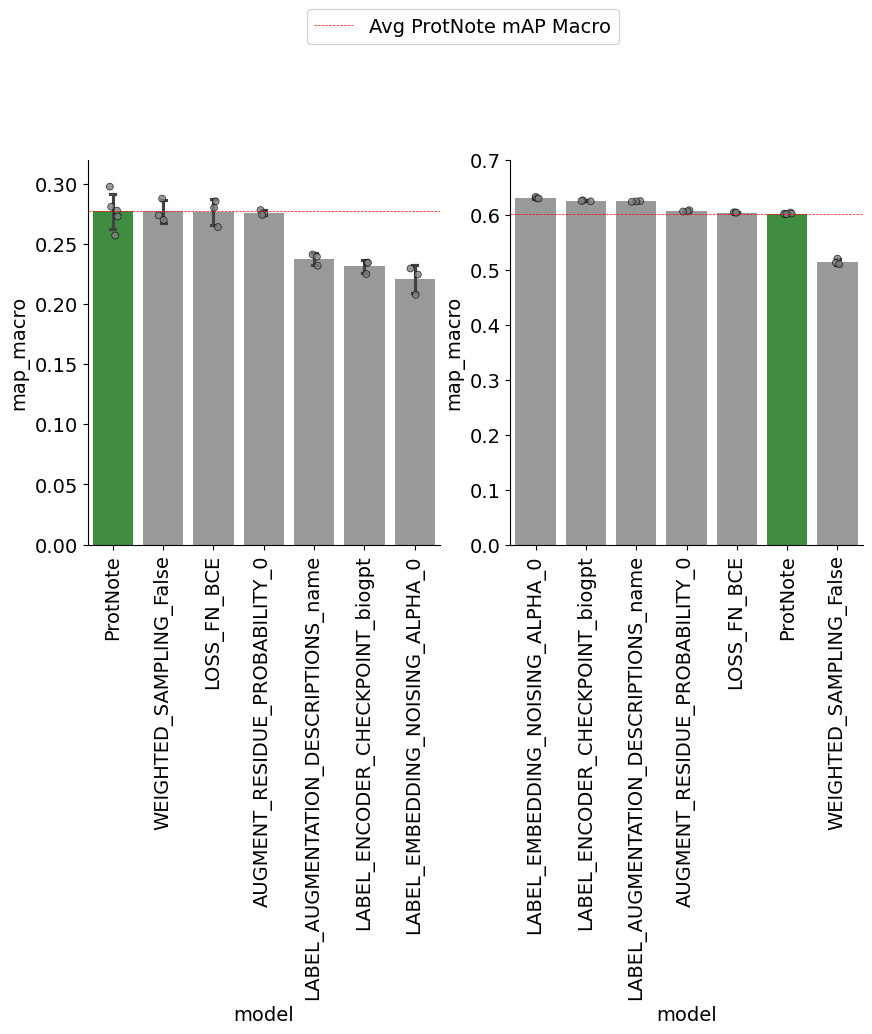

In [83]:

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=False)

test_ablations.groupby(['dataset_name','model'])[['map_macro']].mean()
for idx,dataset_name in enumerate(["TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES","VAL_DATA_PATH"]):
    test_ablations_plot = test_ablations.query('dataset_name ==@dataset_name').sort_values(by='map_macro',ascending=False)
    
    best_models = test_ablations_plot.groupby(['model'])[['map_macro']].mean().reset_index().sort_values(by='map_macro',ascending=False)
    palette = ['green' if m=='ProtNote' else 'grey' for m in best_models["model"].tolist()]

    sns.barplot(errorbar='sd',
                capsize = 0.1,
                # err_kws={'linewidth':1.3},
                data = test_ablations_plot,
                x='model',
                y='map_macro',
                alpha=0.8,
                palette = palette,
                ax=axes[idx],
                order=best_models['model']
                )
    
    sns.stripplot(
                edgecolor = 'black',
                linewidth=0.5,
                x='model',
                y='map_macro',
                data = test_ablations_plot,
                alpha=0.8,
                palette = ["grey"]*len(best_models),
                # dodge=True,
                ax=axes[idx],
                order=best_models['model']
                )

    axes[idx].axhline(y=test_ablations_plot.query('model=="ProtNote"')['map_macro'].mean(),
                color='red',
                linestyle='--',
                linewidth=0.5,
                zorder=3,
                label='Avg ProtNote mAP Macro' if idx == 0 else None
                )

    ylim= (0,0.32) if dataset_name == "TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES" else (0,0.7)
    axes[idx].set_ylim(*ylim)
    axes[idx].tick_params(axis='x', rotation=90)

sns.despine()
# fig.legend()
fig.legend(markerscale=1, bbox_to_anchor=(0.5, 1.2), loc='upper center')
save_fig('../outputs/figures/ablations')
plt.show()


# BLAST vs ProtNote runtimes

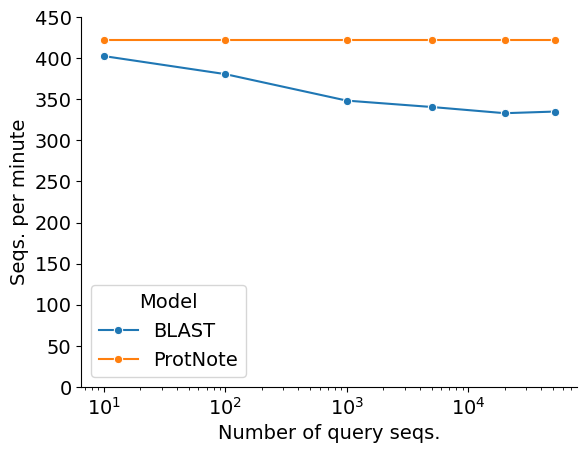

In [18]:
runtimes = pd.read_excel('../outputs/results/blast runtime.xlsx',sheet_name='merged')
runtimes = runtimes.rename(columns={'BLAST seqs per minute':'BLAST',
                         'ProtNote seqs per minute':'ProtNote',
                         'Num Query Seqs':'Number of query seqs.'}).melt(id_vars=['Number of query seqs.'],
              value_vars=['BLAST','ProtNote'],
              value_name='Seqs. per minute',
              var_name='Model')

sns.lineplot(data = runtimes, x  = 'Number of query seqs.',y='Seqs. per minute',hue='Model',marker='o')
plt.ylim(0,450)
sns.despine()
plt.xscale('log')
save_fig('../outputs/figures/runtimes')


## Impact of GO graph change

In [85]:
updated_test_set = metrics_by_go_ontology(df_logits=pd.read_hdf(f'../outputs/results/test_logits_GO_TEST_2024_PINF_VOCAB_DATA_PATH_proteinfer13703706.h5',key='logits_df'),
                    df_labels=pd.read_hdf(f'../outputs/results/test_labels_GO_TEST_2024_PINF_VOCAB_DATA_PATH_proteinfer13703706.h5',key='labels_df'),
                    graph=graph,
                    device=device,
                    threshold=threshold)
updated_test_set = pd.DataFrame(updated_test_set)[['All']]\
    .reset_index()\
    .rename(columns={'index':'metric','All':'Updated Test Set (2024), ProteInfer vocabulary'})\
    .query('metric in ["mAP Macro","mAP Micro"]')

original_test_set = supervised_final_metrics_df\
    .query('model == "Proteinfer" and metric in ["mAP Macro","mAP Micro"]')\
    .groupby(['metric'])[['All']].mean()\
    .rename(columns = {'All':'Original Test Set (2019)'})\
    .reset_index()

data_comparison = original_test_set.merge(updated_test_set,on='metric')
data_comparison.iloc[:,1:] = data_comparison.iloc[:,1:]*100

data_comparison['Difference'] = data_comparison['Updated Test Set (2024), ProteInfer vocabulary'] - data_comparison['Original Test Set (2019)']

In [87]:
data_comparison

,metric,Original Test Set (2019),"Updated Test Set (2024), ProteInfer vocabulary",Difference
0,mAP Macro,64.176664,52.502781,-11.673883
1,mAP Micro,90.324956,67.808455,-22.516501


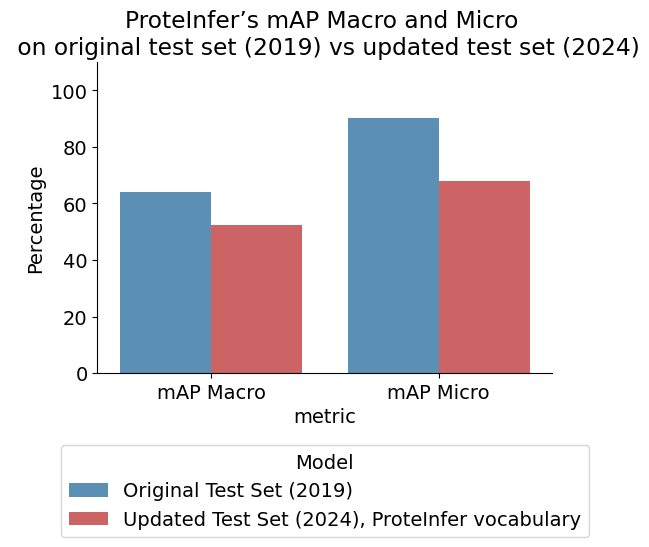

In [86]:
palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:4]
fig,ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=data_comparison.melt(id_vars=['metric'],
                 value_vars=['Original Test Set (2019)','Updated Test Set (2024), ProteInfer vocabulary'],
                 value_name='Percentage',
                 var_name='Test Set'),
            x = 'metric',
            y='Percentage',
            hue='Test Set',
            alpha=0.8,
            palette = palette_,
            ax=ax
            )

plt.ylim(0,110)
plt.title('ProteInfer’s mAP Macro and Micro \n on original test set (2019) vs updated test set (2024)')
sns.despine()
plt.legend(title='Model', bbox_to_anchor=(0.5, -0.2), loc='upper center')
plt.tight_layout()
save_fig('../outputs/figures/impact_of_go_graph_change')
plt.show()


# Explorting zero shot predictions

Get AUPRC (a.k.a AP) by label for both zero shot tasks

In [12]:
test_sets = [('TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES','GO'),('TEST_EC_DATA_PATH_ZERO_SHOT','EC')]
metrics = ['mAP Macro','mAP Micro']
model = 'ProtNote'
auprc_by_label_df = []
for test_set,task in test_sets:
    labels_df = zero_shot_labels[test_set][-1]
    test_name = zero_shot_labels[test_set][0]
    if test_set not in zero_shot_predictions[model]:
        continue

    for seed_idx,logits_df in enumerate(zero_shot_predictions[model][test_set]):
        auprc_by_label = multilabel_auprc(input = torch.tensor(logits_df.values,device='cuda'),
                                target = torch.tensor(labels_df.values,device='cuda'),
                                num_labels = logits_df.shape[1],
                                average=None
                                )
        
        auprc_by_label = pd.DataFrame(auprc_by_label.cpu().numpy()[:,None],index=labels_df.columns,columns=['AUPRC'])
        auprc_by_label['seed'] = seed_idx
        auprc_by_label['task'] = task
        auprc_by_label['test_name'] = test_name
        auprc_by_label_df.append(auprc_by_label)
auprc_by_label_df = pd.concat(auprc_by_label_df)



Map new annotations from zero shot GO test set to closest training set annotation

In [13]:
label_embeddings = "2024_E5_multiling_inst_frozen_label_embeddings_mean"
# label_embeddings = "2024_BioGPT_frozen_label_embeddings_mean"
zero_shot_labels = pd.read_hdf("../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_seed_replicates_v9_42_sum_last_epoch.h5",
                               key="labels_df")
vocabularies = generate_vocabularies(file_path=str('../data/swissprot/proteinfer_splits/random/full_GO.fasta'))

embeddings = torch.load(f"../data/embeddings/{label_embeddings}.pt")
embeddings_idx = torch.load(f"../data/embeddings/{label_embeddings}_index.pt")

# Select embeddings based on name / short definition
embedding_mask = embeddings_idx["description_type"] == "name"
embeddings_idx = embeddings_idx[embedding_mask].reset_index(drop=True)
embeddings = embeddings[embedding_mask]

# Create embeddings matrix of known proteinfer GO Term definitions
train_embeddings_mask = embeddings_idx["id"].isin(vocabularies["label_vocab"])
train_embeddings_idx = embeddings_idx[train_embeddings_mask].reset_index(drop=True)
train_embeddings = embeddings[train_embeddings_mask]

# Create embedding matrix of the new/unknown GO Term definitions
zero_shot_embeddings_mask = embeddings_idx["id"].isin(zero_shot_labels.columns)
zero_shot_embeddings_idx = embeddings_idx[
    zero_shot_embeddings_mask
].reset_index(drop=True)
zero_shot_embeddings = embeddings[zero_shot_embeddings_mask]


# Create description mapping from seen to new
label_train_2_zero_shot_similarities = (
    torch.nn.functional.normalize(zero_shot_embeddings)
    @ torch.nn.functional.normalize(train_embeddings).T
)
go_zero_shot_label_mapping = {
    zero_shot_embeddings_idx["id"]
    .iloc[zero_shot_label_idx]: {
        'train_id':train_embeddings_idx["id"].iloc[train_label_idx.item()],
        'zero_shot_id_description':zero_shot_embeddings_idx["description"].iloc[zero_shot_label_idx].split('Query: ')[-1],
        'train_id_description':train_embeddings_idx["description"].iloc[train_label_idx.item()].split('Query: ')[-1],
        'similarity':label_train_2_zero_shot_similarities[zero_shot_label_idx,train_label_idx].item()
        }
    for zero_shot_label_idx, train_label_idx in enumerate(
        label_train_2_zero_shot_similarities.max(dim=-1).indices
    )
}

# Sample 100 zero-shot labels from leaf nodes only dataset
np.random.seed(42)
go_zero_shot_sampled_terms = set(np.random.choice(list(set(go_zero_shot_label_mapping.keys()) & set(auprc_by_label_df.index)),size=100,replace=False))

In [14]:
label_embeddings_new = "ecv1_E5_multiling_inst_frozen_label_embeddings_mean"
# label_embeddings_new = "ecv1_BioGPT_frozen_label_embeddings_mean"
zero_shot_labels = pd.read_hdf("../outputs/results/test_1_labels_TEST_EC_DATA_PATH_ZERO_SHOT_seed_replicates_v9_42_sum_last_epoch.h5",
                               key="labels_df")

new_embeddings_path = f"../data/embeddings/{label_embeddings_new}.pt"
new_embeddings_idx_path = f"../data/embeddings/{label_embeddings_new}_index.pt"

embeddings_new = torch.load(new_embeddings_path)
embeddings_idx_new = torch.load(new_embeddings_idx_path)

# Create embedding matrix of the new/unknown GO Term definitions
embedding_mask_new = embeddings_idx_new["description_type"] == "name"
embeddings_idx_new = embeddings_idx_new[embedding_mask_new].reset_index(
    drop=True
)
embeddings_new = embeddings_new[embedding_mask_new]

zero_shot_embeddings_mask = embeddings_idx_new["id"].isin(
    zero_shot_labels.columns
)
zero_shot_embeddings_idx = embeddings_idx_new[
    zero_shot_embeddings_mask
].reset_index(drop=True)
zero_shot_embeddings = embeddings_new[zero_shot_embeddings_mask]


# Create description mapping from seen to new
label_train_2_zero_shot_similarities = (
    torch.nn.functional.normalize(zero_shot_embeddings)
    @ torch.nn.functional.normalize(train_embeddings).T
)
ec_zero_shot_label_mapping = {
    zero_shot_embeddings_idx["id"]
    .iloc[zero_shot_label_idx]: {
        'train_id':train_embeddings_idx["id"].iloc[train_label_idx.item()],
        'zero_shot_id_description':zero_shot_embeddings_idx["description"].iloc[zero_shot_label_idx].split('Query: ')[-1],
        'train_id_description':train_embeddings_idx["description"].iloc[train_label_idx.item()].split('Query: ')[-1],
        'similarity':label_train_2_zero_shot_similarities[zero_shot_label_idx,train_label_idx].item()
        }
    for zero_shot_label_idx, train_label_idx in enumerate(
        label_train_2_zero_shot_similarities.max(dim=-1).indices
    )
}


# Sample 100 zero-shot labels for EC dataset
np.random.seed(42)
ec_zero_shot_sampled_terms = set(np.random.choice(list(ec_zero_shot_label_mapping.keys()),size=100,replace=False))

Merge ec and go sampled terms

In [15]:
zero_shot_sampled_terms = go_zero_shot_sampled_terms.union(ec_zero_shot_sampled_terms)
all_zero_shot_terms = pd.DataFrame({**ec_zero_shot_label_mapping,**go_zero_shot_label_mapping}).T

AUPRC by similarity between query label and closest training label

In [16]:
auprc_by_label_df['closest_training_similarty'] = auprc_by_label_df.index.map(lambda x : all_zero_shot_terms.loc[x,'similarity']).values
auprc_by_label_df['closest_training_id'] = auprc_by_label_df.index.map(lambda x : all_zero_shot_terms.loc[x,'train_id']).values
auprc_by_label_df['closest_training_id_ontology'] = auprc_by_label_df['closest_training_id'].map(lambda go_term: graph_2019.nodes[go_term]["namespace"] if go_term in graph_2019.nodes else "missing")

/tmp/ipykernel_1413562/4254717354.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['closest_training_similarty_bin_label'] = pd.qcut(temp['closest_training_similarty'],q=quantiles)
/tmp/ipykernel_1413562/4254717354.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['closest_training_similarty_bin'] = pd.qcut(temp['closest_training_similarty'],q=quantiles,labels=False)
/tmp/ipykernel_1413562/4254717354.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr


 GO:  SignificanceResult(statistic=0.312860267076334, pvalue=6.883440296800275e-47) 


 EC:  SignificanceResult(statistic=0.2180508330320993, pvalue=3.6457941751477595e-136) 



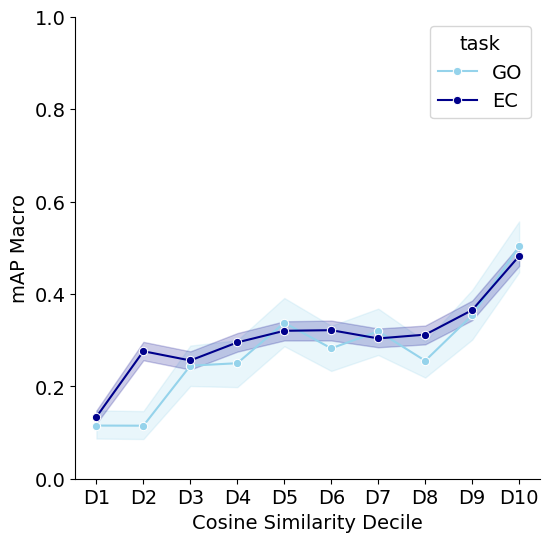

In [17]:
quantiles = 10

pr_curve_df = []
for task in ['GO','EC']:
    temp = auprc_by_label_df.query('task == @task')
    temp['closest_training_similarty_bin_label'] = pd.qcut(temp['closest_training_similarty'],q=quantiles)
    temp['closest_training_similarty_bin'] = pd.qcut(temp['closest_training_similarty'],q=quantiles,labels=False)
    temp['closest_training_similarty_bin']+=1
    spearman = spearmanr(temp['closest_training_similarty_bin'],temp['AUPRC'])
    print('\n========\n',f'{task}: ',spearman,'\n========\n')
    pr_curve_df.append(temp)
pr_curve_df = pd.concat(pr_curve_df)




fig,ax = plt.subplots(figsize=(6,6))
sns.lineplot(data = pr_curve_df,
             x='closest_training_similarty_bin',
             y='AUPRC',
             marker='o',
             hue='task',
            #  style='task',
             errorbar=('ci',95),
             palette=['#95D3EB',
                      'darkblue'#   '#6793A3'
                      ]
             )

plt.ylim(0,1)
ax.set(xlabel='Cosine Similarity Decile',
    ylabel='mAP Macro',
    # title = f'Zero-shot mAP Macro by cosine similarity between query term and closest training term'
    )
ax.set_xticks(range(1,quantiles+1))
ax.set_xticklabels([f'D'+str(i) for i in range(1,quantiles+1)])
sns.despine()
save_fig(f'../outputs/figures/zero_shot_similarity')
plt.show()

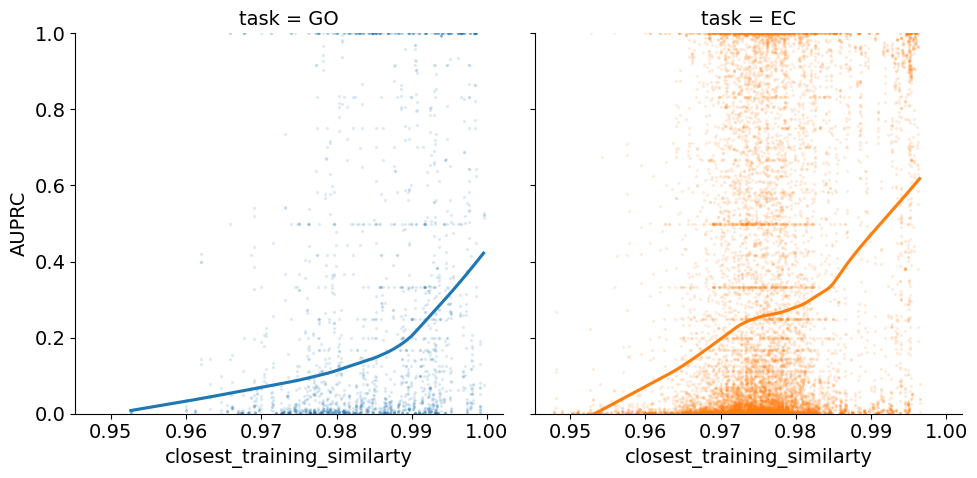

In [37]:
# fig,ax = plt.subplots(figsize=(6,6))
sns.lmplot(data = auprc_by_label_df,
            x='closest_training_similarty',
            y='AUPRC',
            lowess=True,
            col='task',
            hue='task',
            facet_kws=(dict(sharey=True,sharex=True)),
            scatter_kws={'alpha':0.1,'s':2}
            #  style='task',
            # errorbar=('ci',95),
            # palette=['#95D3EB',
            #         'darkblue'#   '#6793A3'
            #         ]
            )

plt.ylim(0,1)
ax.set(xlabel='Closest Training Term Cosine Similarity',
    ylabel='AUPRC',
    # title = f'Zero-shot mAP Macro by cosine similarity between query term and closest training term'
    )
sns.despine()
# plt.yscale("log")
# save_fig(f'../outputs/figures/zero_shot_similarity')
plt.show()

Examples of new zero shot labels with their closest training set label

In [77]:
all_zero_shot_terms

,train_id,zero_shot_id_description,train_id_description,similarity
EC:1.-.-.-,GO:0016491,Oxidoreductases,oxidoreductase activity,0.988505
EC:1.1.-.-,GO:0016614,"Oxidoreductases, acting on the CH-OH group of ...","oxidoreductase activity, acting on CH-OH group...",0.995335
EC:1.1.1.-,GO:0016616,"Oxidoreductases, acting on the CH-OH group of ...","oxidoreductase activity, acting on the CH-OH g...",0.99507
EC:1.1.2.-,GO:0016898,"Oxidoreductases, acting on the CH-OH group of ...","oxidoreductase activity, acting on the CH-OH g...",0.995268
EC:1.1.3.-,GO:0016899,"Oxidoreductases, acting on the CH-OH group of ...","oxidoreductase activity, acting on the CH-OH g...",0.995139
...,...,...,...,...
GO:0180010,GO:0031440,"co-transcriptional mRNA 3'-end processing, cle...",regulation of mRNA 3'-end processing,0.98065
GO:0180015,GO:1901642,nucleoside import across plasma membrane,nucleoside transmembrane transport,0.9847
GO:0180019,GO:0044816,Knl1/Spc105 complex,Nsk1-Dlc1 complex,0.970349
GO:0180022,GO:1990112,RQC-trigger complex,RQC complex,0.986374


In [200]:
all_zero_shot_terms['task'] = all_zero_shot_terms.index.map(lambda x: x[:2])
all_zero_shot_terms.loc[zero_shot_sampled_terms].to_excel('../outputs/results/zero_shot_sampled_terms.xlsx')

/tmp/ipykernel_3305874/1137935323.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  all_zero_shot_terms.loc[zero_shot_sampled_terms].to_excel('../outputs/results/zero_shot_sampled_terms.xlsx')


In [68]:
# dataset = read_jsonl('../data/temp/proteinfer_go_random_test.jsonl',verbose=False)
# all_labels = get_all_labels(dataset, predictions)
# true_labels, pred_scores = preprocess_preds(
#     dataset, predictions, all_labels
# )

In [69]:
#WARNING: protex may evaluate using sequences with zero labels and/or labels that are always zero.
# If the former is true, the f1 micro could be artificially lower b/c rows with zero labels are counted as negatives based on preprocess_preds
# which means that these rows don't contribute tp or fn, but could contribute to fp, lowering precision and therefore f1 micro.
# if the latter is true, then micro scores are unaffected, but macro scores are artificially lower.

In [8]:
from collections import defaultdict

#Read protex predictions
pridctions_file_name = "proteinfer-random-go-test-protex.jsonl"
predictions_blob_name = os.path.join(PREDICTIONS_DIR,pridctions_file_name)
predictions = read_jsonl_from_gcs(BUCKET_NAME,predictions_blob_name)

#Read ProtNote/ProteInfer labels
labels_df = pd.read_hdf('../outputs/results/test_1_labels_TEST_DATA_PATH_seed_replicates_v9_12_sum_last_epoch.h5',key='labels_df')


# Transform Protex predictions to a dataframe and filter
selected_sequences = set(labels_df.index)
selected_labels = set(labels_df.columns)

protex_logits_df = defaultdict(dict)

for record in predictions:
    seq,label = record['inputs']['accession'],record['inputs']['label']
    if (seq in selected_sequences) & (label in selected_labels):
        protex_logits_df[seq][label] = record['score']

protex_logits_df = pd.DataFrame.from_dict(protex_logits_df,orient='index').fillna(NEG_INF)
protex_labels_df = labels_df.loc[protex_logits_df.index,protex_logits_df.columns]

In [9]:
protex_th = torch.sigmoid(torch.tensor(-0.8648852109909058)).item()

In [ ]:
metrics_df = []
metrics = metrics_by_go_ontology(
    protex_logits_df, protex_labels_df, graph_2019, 'cpu', protex_th
)

metrics = pd.DataFrame(metrics)
metrics["model"] = 'Protex'
metrics["test_name"] = 'TEST_DATA_PATH'
metrics.index.name = "metric"
metrics = metrics.set_index(["model", "test_name"], append=True)
metrics_df.append(metrics)


metrics_df = pd.concat(metrics_df)
metrics_df.columns = metrics_df.columns.map(ontology2alias)

NameError: name 'metrics_df' is not defined

In [20]:
metrics_df

,,,All,BP,CC,MF
metric,model,test_name,,,,
mAP Macro,Protex,TEST_DATA_PATH,0.740669,0.687573,0.748590,0.897479
mAP Micro,Protex,TEST_DATA_PATH,0.951931,0.934264,0.938488,0.989472
f1_macro,Protex,TEST_DATA_PATH,0.665346,0.614595,0.670668,0.816038
f1_micro,Protex,TEST_DATA_PATH,0.910760,0.890001,0.889563,0.967354


In [22]:
supervised_final_metrics_df

,,,All,BP,CC,MF
metric,model,test_name,,,,
mAP Macro,Proteinfer,GO 2019 Supervised,0.641584,0.587778,0.634341,0.806225
mAP Micro,Proteinfer,GO 2019 Supervised,0.902640,0.873064,0.892922,0.964210
f1_macro,Proteinfer,GO 2019 Supervised,0.565443,0.517885,0.546431,0.716058
f1_micro,Proteinfer,GO 2019 Supervised,0.866264,0.839542,0.843718,0.936359
mAP Macro,Proteinfer,GO 2019 Supervised,0.642296,0.588452,0.637824,0.805785
mAP Micro,Proteinfer,GO 2019 Supervised,0.904254,0.875612,0.892676,0.965279
f1_macro,Proteinfer,GO 2019 Supervised,0.567249,0.517938,0.554063,0.720674
f1_micro,Proteinfer,GO 2019 Supervised,0.869176,0.843214,0.845651,0.938379
mAP Macro,Proteinfer,GO 2019 Supervised,0.644078,0.590901,0.636684,0.806892
